# Extract the dominant colors of skin, eyes and hair

In [1]:
import cv2
import numpy as np
import dlib
import Queue
import matplotlib.pyplot as plt
import glob
import time
from collections import OrderedDict
from IPython.core.debugger import Tracer
%matplotlib inline

In [40]:
FACIAL_LANDMARKS_IDXS = OrderedDict([
    #("mouth", (48, 68)),
    ("right_eyebrow", (17, 22)), # hair
    #("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)), # eye
    #("left_eye", (42, 48)),
    ("nose", (27, 35)), # skin
    #("jaw", (0, 17))
])

def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

# Image is already a face no need to extract the face
def extract_face_parts(image, predictor_path):
    predictor = dlib.shape_predictor(predictor_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rect = dlib.rectangle(left=0, top=0, right=image.shape[1], bottom=image.shape[0])
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
    
    rois = []

    for (name, (i, j)) in FACIAL_LANDMARKS_IDXS.items():
        (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
        rois.append((x, y, w, h))
        
    # reduce height of nose
    nose = rois[2]
    nose_h = int(nose[3] * 0.75)
    nose = (nose[0], nose[1], nose[2], nose_h)
    rois[2] = nose
        
    return rois

[[ 33.57872391  39.09786987  41.62127686]
 [ 47.84000015  71.94667053  93.85333252]]
[[  32.04917908   38.91802979   44.44261932]
 [  62.           88.57575989  108.03030396]
 [  46.38461685   62.92307663   78.30769348]]
[[  47.91716003   77.21893311  111.90532684]
 [  69.66397095  120.57894897  170.02429199]]
[[  95.87765503  120.54786682  129.96276855]
 [  73.95587921   99.66912079  113.21323395]]
[[  36.90566254   50.83018875   55.01886749]
 [  70.53845978   87.92308044  102.66667175]
 [ 160.          165.5         152.5       ]]
[[  82.35293579  106.6348877   131.49290466]
 [  41.5118103    73.81890106  113.96850586]]
[[  49.33193588   69.55042267   88.20588684]
 [  75.40931702  101.14706421  132.95098877]]
[[  81.8777771    99.5         134.0111084 ]
 [  60.48684311   72.25         84.48683929]
 [ 130.21739197  137.04348755  154.30435181]]
[[ 109.3991394   146.63519287  200.27897644]
 [  75.27797699  112.24909973  153.42959595]]
[[  74.722435     80.16729736   84.14828491]
 [  91.

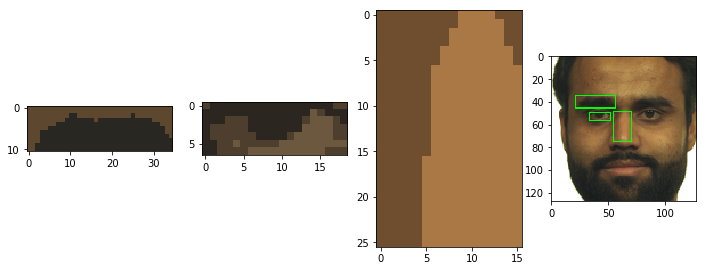

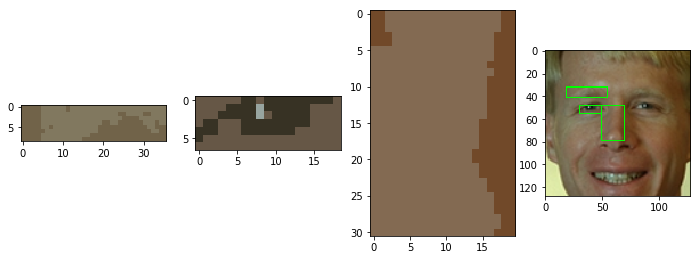

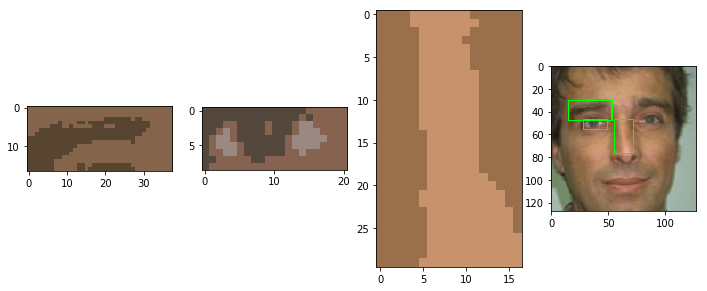

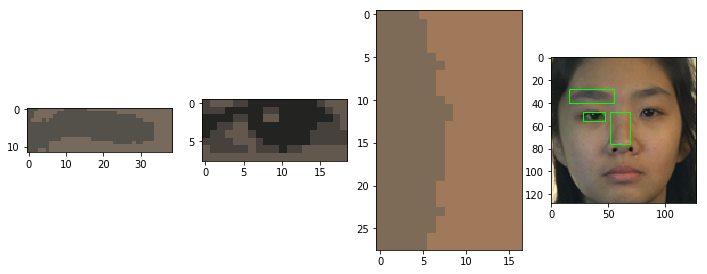

In [47]:
def try_it(face_path):
        
    image = cv2.imread(face_path)
    image2 = cv2.imread(face_path)
    image_f = image.astype(float)
    rois = extract_face_parts(image, "shape_predictor_68_face_landmarks.dat")
    
    l = len(rois)
    assert l == 3
    f, ax = plt.subplots(1, 4, figsize = (12, 12))
    for K, roi, title, i in zip([2, 3, 2], rois, ["eyebrow", "eye", "nose"], range(l)):
        (x, y, w, h) = roi

        part = image[y:y + h, x:x + w, :]
        Z = part.reshape((-1, 3))
        Z = np.float32(Z)
        
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
        print center

        # Now convert back into uint8, and make original image
        center = np.uint8(center)
        res = center[label.flatten()]
        res2 = res.reshape((part.shape))

        ax[i].imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB))
        cv2.rectangle(image2, (x, y), (x+w, y+h), (0, 255, 0), 1)
        

    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    plt.figure()
    
    
try_it("test_autumn.ppm")
try_it("test_spring.ppm")
try_it("test_summer.ppm")
try_it("test_winter.ppm")
       